In [1]:
path = 'https://raw.githubusercontent.com/LunusMax/football-data/refs/heads/main/Neymar/neymar_stats.csv'

In [8]:
import pandas as pd

data = pd.read_csv(path, sep=';')

In [9]:
data.head()

,Ano,Time,MP,MIN_abs,GLS_abs,AST_abs,ASR,MIN_per90,GLS_per90,AST_per90
0,2025,Santos,19,1372,6,3,7.34,72.2,0.4,0.2
1,24/25,Al-Hilal,2,42,0,0,6.60,21.0,0.0,0.0
2,23/24,Al-Hilal,5,386,1,2,7.58,77.2,0.2,0.5
3,22/23,PSG,29,2361,18,16,7.74,81.4,0.7,0.6
4,21/22,PSG,29,2353,14,8,7.36,81.1,0.5,0.3


In [10]:
data['PG'] = data['GLS_abs'] + data['AST_abs']
data.head()

,Ano,Time,MP,MIN_abs,GLS_abs,AST_abs,ASR,MIN_per90,GLS_per90,AST_per90,PG
0,2025,Santos,19,1372,6,3,7.34,72.2,0.4,0.2,9
1,24/25,Al-Hilal,2,42,0,0,6.60,21.0,0.0,0.0,0
2,23/24,Al-Hilal,5,386,1,2,7.58,77.2,0.2,0.5,3
3,22/23,PSG,29,2361,18,16,7.74,81.4,0.7,0.6,34
4,21/22,PSG,29,2353,14,8,7.36,81.1,0.5,0.3,22


In [12]:
data['PG_per90'] = (data['PG'] * 90) / (data['MIN_abs'])
data = data.drop('MIN_per90', axis=1)
data.head()

,Ano,Time,MP,MIN_abs,GLS_abs,AST_abs,ASR,GLS_per90,AST_per90,PG,PG_per90
0,2025,Santos,19,1372,6,3,7.34,0.4,0.2,9,0.590379
1,24/25,Al-Hilal,2,42,0,0,6.60,0.0,0.0,0,0.000000
2,23/24,Al-Hilal,5,386,1,2,7.58,0.2,0.5,3,0.699482
3,22/23,PSG,29,2361,18,16,7.74,0.7,0.6,34,1.296061
4,21/22,PSG,29,2353,14,8,7.36,0.5,0.3,22,0.841479


In [13]:
data.columns

Index(['Ano', 'Time', 'MP', 'MIN_abs', 'GLS_abs', 'AST_abs', 'ASR',
       'GLS_per90', 'AST_per90', 'PG', 'PG_per90'],
      dtype='object')

In [42]:
import os
from pathlib import Path
import urllib.request
from PIL import Image

# 1) baixar
BASE_RAW = "https://raw.githubusercontent.com/LunusMax/football-data/main/Neymar/logos"
files = {
    "Santos": "santos.png",
    "Barcelona": "barcelona.png",
    "PSG": "psg.png",
    "Al-Hilal": "alhilal.png",
}

raw_dir = Path("./logos_raw")
raw_dir.mkdir(parents=True, exist_ok=True)

for team, fname in files.items():
    url = f"{BASE_RAW}/{fname}"
    dest = raw_dir / fname
    if not dest.exists():
        print(f"Baixando {team} -> {url}")
        urllib.request.urlretrieve(url, dest)

# 2) padronizar para 40x40 (preserva proporção e centraliza em canvas 40x40)
out_dir = Path("./logos_40")
out_dir.mkdir(parents=True, exist_ok=True)

TARGET = (27, 27)

def to_40x40(src_path, dst_path):
    img = Image.open(src_path).convert("RGBA")
    # encaixa dentro de 40x40 mantendo proporção
    img.thumbnail(TARGET, Image.LANCZOS)
    # centraliza em um canvas 40x40 transparente
    canvas = Image.new("RGBA", TARGET, (0, 0, 0, 0))
    x = (TARGET[0] - img.width) // 2
    y = (TARGET[1] - img.height) // 2
    canvas.paste(img, (x, y))
    canvas.save(dst_path)

for team, fname in files.items():
    to_40x40(raw_dir / fname, out_dir / fname)

# mapeamento final para usar no gráfico
logos_40 = {
    "Santos": str(out_dir / "santos.png"),
    "Barcelona": str(out_dir / "barcelona.png"),
    "PSG": str(out_dir / "psg.png"),
    "Al-Hilal": str(out_dir / "alhilal.png"),
}


In [43]:
import pandas as pd

# partindo do seu DataFrame existente: data
# colunas: ['Ano','Time','MP','MIN_abs','GLS_abs','AST_abs','ASR','GLS_per90','AST_per90','PG','PG_per90']

def ano_ord(a: str) -> float:
    # "24/25" deve vir antes de "2025"
    if "/" in a:
        left, _ = a.split("/")
        return 2000 + int(left)     # 24/25 -> 2024
    return float(a) + 0.5           # 2025 -> 2025.5

df = data.copy()
df["Ano_ord"] = df["Ano"].apply(ano_ord)
df = df.sort_values("Ano_ord").reset_index(drop=True)


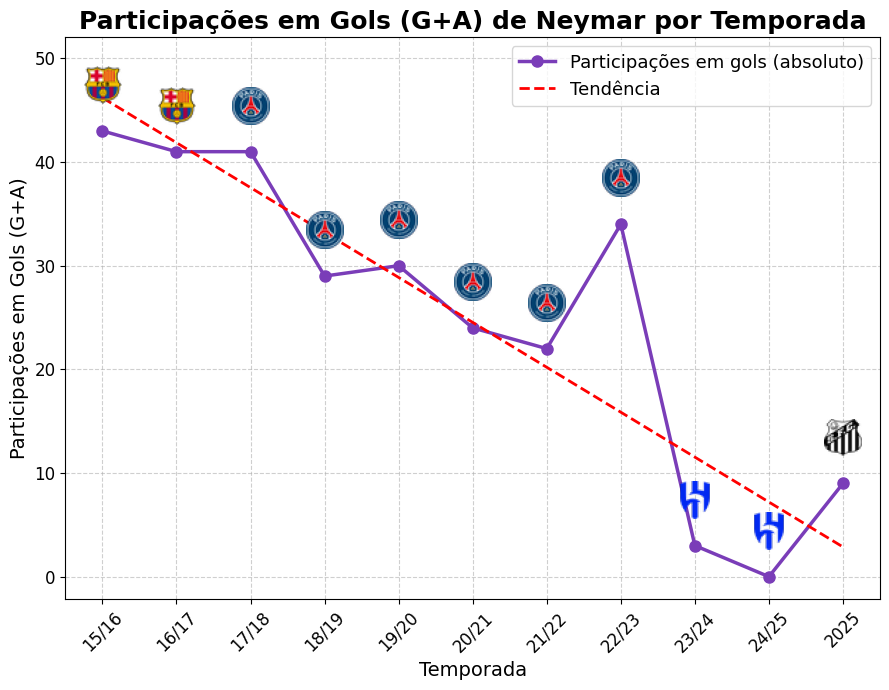

In [49]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

# x = índices (mantemos sua lógica visual), y = PG
x = np.arange(len(df))
y = df["PG"].to_numpy()

plt.figure(figsize=(9,7))

# ===== Linha principal (roxo menos saturado) =====
plt.plot(
    x, y,
    marker="o",
    linewidth=2.5,
    markersize=8,
    label="Participações em gols (absoluto)",
    color="#7A3DB8"
)

# ===== Reta de tendência (exclui o último ponto e continua até o fim) =====
x_fit = x[:-1]
y_fit = y[:-1]
coef = np.polyfit(x_fit, y_fit, 1)     # regressão linear na escala dos índices
p = np.poly1d(coef)
x_line = np.linspace(x[0], x[-1], 200) # prolonga até o último índice
plt.plot(x_line, p(x_line), "r--", linewidth=2, label="Tendência")

# ===== Logos (40x40) acima dos pontos =====
yr = np.ptp(y) if np.ptp(y) > 0 else 1.0
y_offset = 0.06 * yr   # ajuste fino (0.04–0.08)
ax = plt.gca()

for xi, (team, yi) in enumerate(zip(df["Time"], y)):
    path = logos_40.get(team)
    if path and os.path.exists(path):
        try:
            img = Image.open(path).convert("RGBA")  # já 40x40
            oi = OffsetImage(img, zoom=1.0)
            ab = AnnotationBbox(
                oi, (xi, yi + y_offset),
                frameon=False,
                box_alignment=(0.5, 0),
                xycoords="data"
            )
            ax.add_artist(ab)
        except Exception:
            plt.text(xi, yi + y_offset, team, ha="center", va="bottom", fontsize=10)
    else:
        plt.text(xi, yi + y_offset, team, ha="center", va="bottom", fontsize=10)

# ===== Estética =====
plt.title("Participações em Gols (G+A) de Neymar por Temporada", fontsize=18, weight="bold")
plt.xlabel("Temporada", fontsize=14)
plt.ylabel("Participações em Gols (G+A)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=13)
plt.xticks(x, df["Ano"].tolist(), fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()

# Margem superior para caber os escudos
ymin = float(y.min()) - 0.05 * yr
ymax = float(y.max()) + y_offset + 0.15 * yr
ax.set_ylim(ymin, ymax)

plt.show()


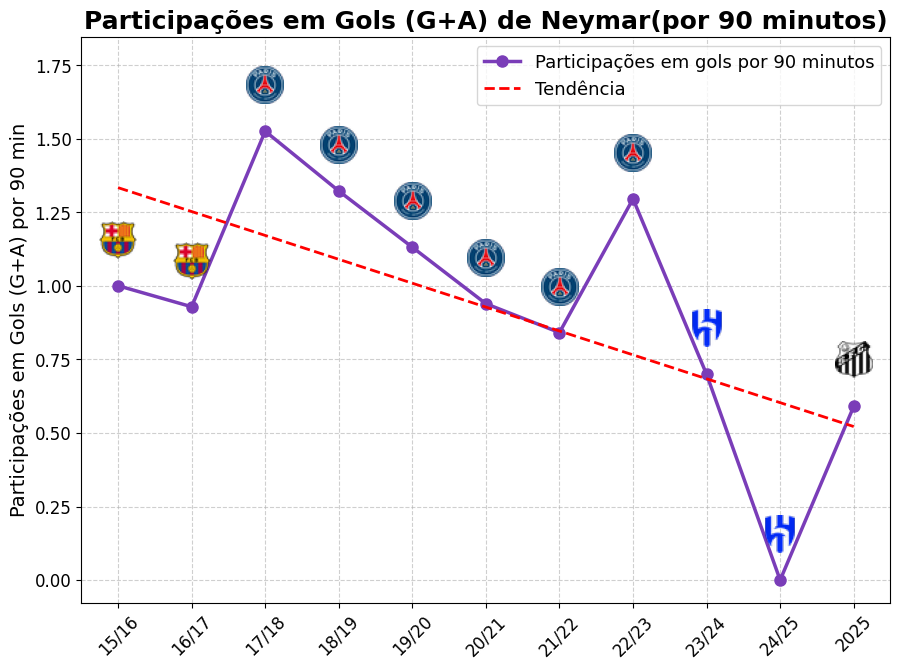

In [53]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

# x = índices (mantemos sua lógica visual), y = PG_per90
x = np.arange(len(df))
y = df["PG_per90"].to_numpy()

plt.figure(figsize=(9,7))

# ===== Linha principal (roxo menos saturado) =====
plt.plot(
    x, y,
    marker="o",
    linewidth=2.5,
    markersize=8,
    label="Participações em gols por 90 minutos",
    color="#7A3DB8"
)

# ===== Reta de tendência (exclui o último ponto e continua até o fim) =====
x_fit = x[:-1]
y_fit = y[:-1]
coef = np.polyfit(x_fit, y_fit, 1)     # regressão linear na escala dos índices
p = np.poly1d(coef)
x_line = np.linspace(x[0], x[-1], 200) # prolonga até o último índice
plt.plot(x_line, p(x_line), "r--", linewidth=2, label="Tendência")

# ===== Logos (40x40) acima dos pontos =====
yr = np.ptp(y) if np.ptp(y) > 0 else 1.0
y_offset = 0.06 * yr   # ajuste fino (0.04–0.08)
ax = plt.gca()

for xi, (team, yi) in enumerate(zip(df["Time"], y)):
    path = logos_40.get(team)
    if path and os.path.exists(path):
        try:
            img = Image.open(path).convert("RGBA")  # já 40x40
            oi = OffsetImage(img, zoom=1.0)
            ab = AnnotationBbox(
                oi, (xi, yi + y_offset),
                frameon=False,
                box_alignment=(0.5, 0),
                xycoords="data"
            )
            ax.add_artist(ab)
        except Exception:
            plt.text(xi, yi + y_offset, team, ha="center", va="bottom", fontsize=10)
    else:
        plt.text(xi, yi + y_offset, team, ha="center", va="bottom", fontsize=10)


# ===== Estética =====
plt.title("Participações em Gols (G+A) de Neymar(por 90 minutos)", fontsize=18, weight="bold")
plt.ylabel("Participações em Gols (G+A) por 90 min", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=13)
plt.xticks(x, df["Ano"].tolist(), fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()

# Margem superior para caber os escudos
ymin = float(y.min()) - 0.05 * yr
ymax = float(y.max()) + y_offset + 0.15 * yr
ax.set_ylim(ymin, ymax)

plt.show()

In [55]:
Kaio_Jorge = {
    "Ano": "2025",
    "Time": "Cruzeiro",
    "MP": 29,         # jogos
    "MIN_abs": 2140,# minutos
    "GLS_abs": 17,    # gols
    "AST_abs": 5,    # assistências
    "ASR": 7.28, # Sofascore Rating fake
    "GLS_per90": 0.7,
    "AST_per90": 0.2,
    "PG": 22,         # G+A absoluto
    "PG_per90": 22*90/2140
}

# adiciona ao DataFrame
data = pd.concat([data, pd.DataFrame([Kaio_Jorge])], ignore_index=True)

/tmp/ipython-input-1480687801.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_plot["Jogador"], fontsize=14, weight="bold")


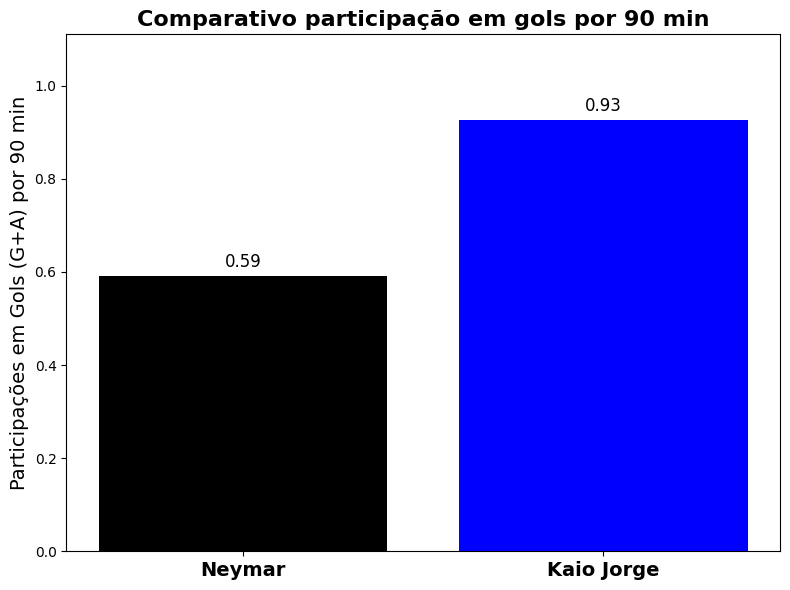

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Filtrar 2025
df_2025 = data.query("Ano == '2025'").copy()

# 2) Escolher os dois jogadores de interesse:
#    regra: maior PG_per90 = Kaio Jorge, menor PG_per90 = Neymar
df_2025_sorted = df_2025.sort_values("PG_per90", ascending=False)

kaio_val   = df_2025_sorted.iloc[0]["PG_per90"]
neymar_val = df_2025_sorted.iloc[-1]["PG_per90"]

# 3) Montar um DF enxuto na ordem desejada (Neymar primeiro, Kaio depois)
df_plot = pd.DataFrame({
    "Jogador": ["Neymar", "Kaio Jorge"],
    "PG_per90": [neymar_val, kaio_val]
})

# 4) Cores fixas
cores = {"Neymar": "black", "Kaio Jorge": "blue"}
bar_colors = [cores[j] for j in df_plot["Jogador"]]

# 5) Plot
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(df_plot["Jogador"], df_plot["PG_per90"], color=bar_colors)

# depois de criar o gráfico
ax.set_xticklabels(df_plot["Jogador"], fontsize=14, weight="bold")

ax.set_ylabel("Participações em Gols (G+A) por 90 min", fontsize=14)
ax.set_title("Comparativo participação em gols por 90 min", fontsize=16, weight="bold")
ax.set_ylim(0, df_plot["PG_per90"].max() * 1.2)

# Rótulos nas barras (sem textos flutuantes)
ax.bar_label(bars, labels=[f"{v:.2f}" for v in df_plot["PG_per90"]], padding=4, fontsize=12)

plt.tight_layout()
plt.show()